datacomp-image.M_32.efc_1000.efs_1000.ck_ts_0.ncheck_100.recall@1000.nthread_48.random.log
datacomp-image.M_32.efc_1000.efs_1000.ck_ts_0.ncheck_100.recall@1000.nthread_48.random.log
(1.00 11.39), (0.98 10.84), (0.97 10.24), (0.95 9.68), (0.94 9.12), (0.92 8.50), (0.91 7.96), (0.90 7.43), (0.88 6.83), (0.86 6.23), (0.84 5.68), (0.84 5.51), (0.84 5.42), (0.84 5.38), (0.83 5.24), (0.83 5.06), (0.83 4.95), (0.82 4.77), (0.82 4.61), (0.82 4.54), (0.81 4.29), (0.81 4.18), (0.80 4.03), (0.80 3.99), (0.80 3.88), (0.80 3.82), (0.79 3.63), (0.79 3.57), (0.79 3.41), (0.78 3.29), (0.78 3.17), (0.77 3.02), (0.77 2.92), (0.77 2.77), datacomp-image.M_32.efc_1000.efs_1000.ck_ts_0.ncheck_100.recall@1000.thr_700.nthread_48.qonly.log
datacomp-image.M_32.efc_1000.efs_1000.ck_ts_0.ncheck_100.recall@1000.thr_700.nthread_48.qonly.log
(1.00 11.16), (0.99 10.82), (0.98 10.26), (0.97 9.85), (0.97 9.25), (0.96 8.73), (0.95 8.15), (0.93 7.58), (0.92 6.95), (0.91 6.41), (0.89 5.85), (0.89 5.72), (0.89 5.61), (0.89

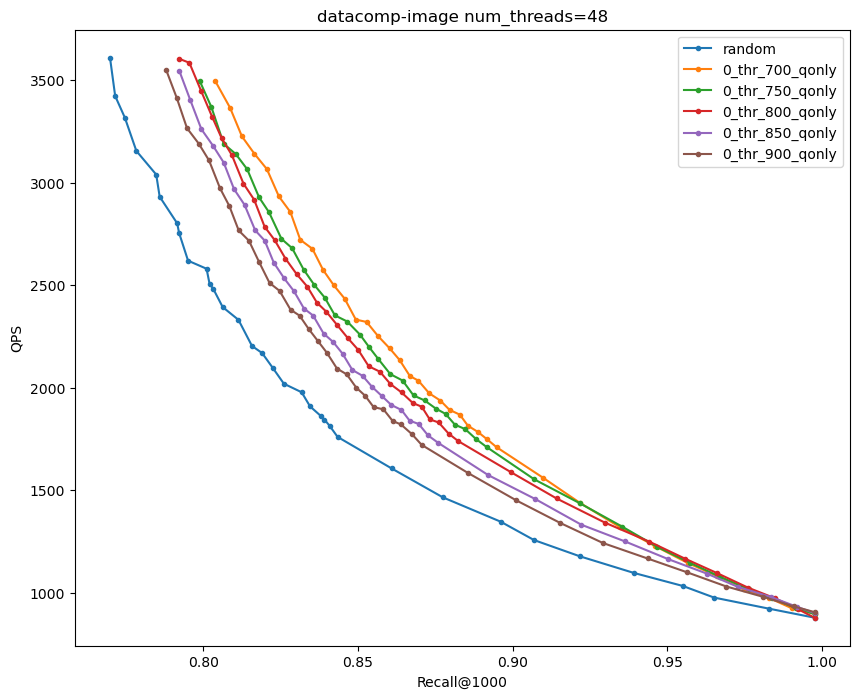

In [20]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt

dataset = 'wikipedia'
dataset = 'deep100m'
dataset = 'datacomp-image'
log_path = "/home/zhengweiguo/liuchengjun/HybridNNS/log/"
config = json.loads(open('config.json').read())
M, efs = config[dataset]["M"], config[dataset]["efs"]
dim = config[dataset]["dim"]
efc = 1000
ck_ts = 2000
k = 1000

num_threads = 48
plt.figure(figsize=(10, 8))

def get_recall_time(prefix):
    print(prefix)
    recall_time = []
    logfile_path = os.path.join(log_path, prefix)
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        curr = []
        for line in lines:
            if 'model_path' in line: continue
            if 'E2E time: ' in line:
                curr.append(float(line.split(': ')[1]))
            elif f'Recall@{k}' in line:
                avg = np.mean(curr)
                curr.clear()
                curr.append(avg)
                curr.append(float(line.split(': ')[1]))
                recall_time.append((curr[1], curr[0]))
                curr = []
    def pareto_frontier(points):
        # Sort the points by recall (descending) then by E2E time (ascending)
        points = sorted(points, key=lambda x: (-x[0], x[1]))
        frontier = []
        for point in points:
            if len(frontier) == 0 or point[1] < frontier[-1][1]:
                frontier.append(point)
        return frontier
    recall_time = pareto_frontier(recall_time)
    print(prefix)
    for recall, time in recall_time:
        print(f'({recall:.2f} {time:.2f})', end=', ')
    plt.plot([x[0] for x in recall_time], [10000 / x[1] for x in recall_time], '.-')
    return recall_time

legends = []

method = 'random'
ck_ts = 0
prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.nthread_{num_threads}.{method}.log'
recall_time_random = get_recall_time(prefix)
legends.append(f'{method}')

# method = 'hnns_optimized'
# ck_ts = 2000
# prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.nthread_{num_threads}.{method}.log'
# recall_time_hnns_optimized_ck_ts_2000 = get_recall_time(prefix)
# legends.append(f'{ck_ts}_{method}')

# method = 'hnns_optimized'
# ck_ts = 1000
# prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.nthread_{num_threads}.{method}.log'
# recall_time_hnns_optimized_ck_ts_1000 = get_recall_time(prefix)
# legends.append(f'{ck_ts}_{method}')

# method = 'hnns_optimized'
# ck_ts = 500
# prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.nthread_{num_threads}.{method}.log'
# recall_time_hnns_optimized_ck_ts_1000 = get_recall_time(prefix)
# legends.append(f'{ck_ts}_{method}')

method = 'qonly'
ck_ts = 0
for thr in range(700, 920, 50):
    prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.thr_{thr}.nthread_{num_threads}.{method}.log'
    recall_time_hnns_optimized_ck_ts_1000 = get_recall_time(prefix)
    legends.append(f'{ck_ts}_thr_{thr}_{method}')


# method = 'hnns'
# ck_ts = 2000
# prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.nthread_{num_threads}.{method}.log'
# recall_time_hnns = get_recall_time(prefix)
# legends.append(f'{ck_ts}_{method}')

print(legends)


# ax1 = plt.axes([0.1, 0.1, 0.8, 0.8])  # [left, bottom, width, height]
# plt.plot([x[0] for x in recall_time_hnns], [10000 / x[1] for x in recall_time_hnns], 'b*-')
# plt.plot([x[0] for x in recall_time_hnns_optimized], [10000 / x[1] for x in recall_time_hnns_optimized], 'g*-')
plt.legend(legends)
# plt.legend(['random', 'hnns'])
plt.xlabel(f'Recall@1000')
plt.title(f'{dataset} num_threads={num_threads}')
plt.ylabel('QPS')

# ax2 = plt.axes([0.05, 0.6, 0.2, 0.3])  # [left, bottom, width, height]，放置在左上角
# x_zoom_random = [x for x in recall_time_random if 0.998 <= x[0] <= 1.000]
# x_zoom_hnns = [x for x in recall_time_hnns if 0.998 <= x[0] <= 1.000]
# plt.plot([x[0] for x in x_zoom_random], [10000 / x[1] for x in x_zoom_random], 'r*-')
# plt.plot([x[0] for x in x_zoom_hnns], [10000 / x[1] for x in x_zoom_hnns], 'b*-')

plt.show()